In [ ]:
import torch
from torchvision.utils import make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
from dataclasses import dataclass

from models import PerceptionModel
from data import build_data_loader

from sklearn.mixture import GaussianMixture
from sklearn.cluster import HDBSCAN, KMeans
from sklearn.preprocessing import normalize

import numpy as np
np.set_printoptions(suppress=True)

In [ ]:
def resize_image(image_tensor, size):
    return F.interpolate( image_tensor.unsqueeze(0), size = ( size, size ),
                          mode = 'bilinear', align_corners = False ).squeeze(0)

def pad_image(image_tensor, target_size=64):
    """
    Pads the input image tensor with a black border so that the final image
    has dimensions (target_size, target_size). The image is centered.
    
    Assumes image_tensor is of shape [C, H, W].
    
    Parameters:
    - image_tensor: torch.Tensor of shape [C, H, W]
    - target_size: Desired output size (both height and width)
    
    Returns:
    - padded_image: torch.Tensor of shape [C, target_size, target_size]
    """
    # Get original image dimensions
    _, H, W = image_tensor.shape
    
    # Compute the padding sizes for height and width
    pad_height = target_size - H
    pad_width = target_size - W
    
    # Ensure that the image is smaller than the target size
    if pad_height < 0 or pad_width < 0:
        raise ValueError("The image dimensions are larger than the target size.")
    
    # Calculate padding for each side (left, right, top, bottom)
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    
    # F.pad expects the padding tuple in the order: (pad_left, pad_right, pad_top, pad_bottom)
    padded_image = F.pad(image_tensor, (pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0)
    return padded_image

In [ ]:

@dataclass
class ConfigBackboneC:
    in_channels: float = 3

@dataclass
class ConfigBackboneT:
    embed_dim: float = 384
    num_heads: float = 12
    depth: float = 6
    num_tokens: float = 4096

model_config = {
    'backbone_c': ConfigBackboneC(),
    'backbone_t': ConfigBackboneT(),
}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
device

In [33]:
model = PerceptionModel( model_config, "./models/", 'encoder_v1', device ).to(device)
model.load()
model.eval()

./models/encoder_v1/checkpoint_0.pth

Unmatched parameters in the pretrained model:

Unmatched parameters in the current model:



<All keys matched successfully>



Loaded from: ./models/encoder_v1 - 0





PerceptionModel(
  (backbone_c): Backbone(
    (stage1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (stage2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (stage3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (def_stage3): Sequential(
      (0): DeformableConv2d(
        (offset_conv): Conv2d(256, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (mask_conv): Conv2d(256, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): BatchNor

In [34]:
data_loader = build_data_loader( 'dataset', batch_size = 4 )

###################################
Using data augmentation parameters:
global_crops_scale: (0.32, 1.0)
global_crops_size: 512
###################################
Dataset loaded with 59473 entries.


In [35]:
data_iter = iter(data_loader)

In [36]:
denormalize = lambda x: 0.5 * x + 0.5

[torch.Size([8, 384, 64, 64]), torch.Size([8, 384, 32, 32]), torch.Size([8, 384, 16, 16])]
tensor(0., device='cuda:0') tensor(2.6875, device='cuda:0') tensor(-2.0155, device='cuda:0') tensor(1.7122, device='cuda:0')


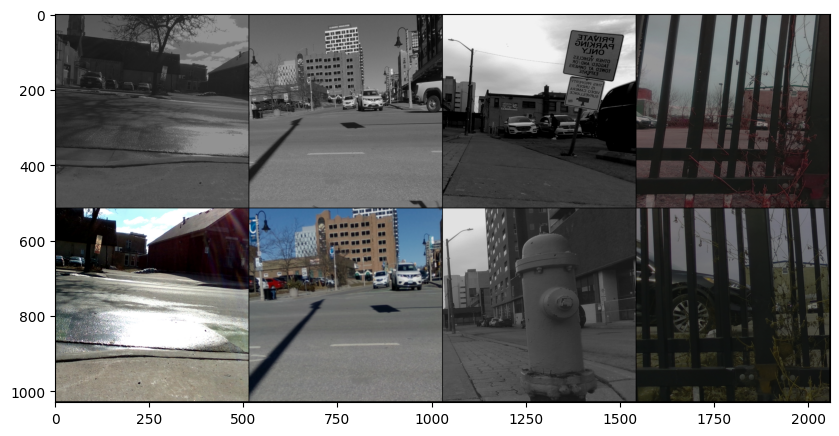

In [37]:
with torch.no_grad():
    with torch.amp.autocast( enabled = True, device_type = "cuda", dtype = torch.bfloat16 ):
        data = next(data_iter)
        images = data['collated_global_crops'].cuda( non_blocking = True )
        result = model( images )
        features = result['feature_layers']
        tokens = [ x['x_norm_patch_tokens'] for x in result['patch_layers'] ]

print( [ f.shape for f in features ] )

tokens = [ 
    tokens[0].view( 8, 64, 64, -1 ).to(torch.float32),
    tokens[1].view( 8, 32, 32, -1 ).to(torch.float32),
    tokens[2].view( 8, 16, 16, -1 ).to(torch.float32),
]

features = [
    features[0].to(torch.float32),
    features[1].to(torch.float32),
    features[2].to(torch.float32),
]

print( features[0].min(), features[0].max(), tokens[0].min(), tokens[0].max() )


# plot the imgae
grid = make_grid( denormalize( images ), nrow = 4, normalize = True ).cpu()

plt.figure( figsize = ( 10, 10 ) )
plt.imshow( grid.permute(1, 2, 0) )
plt.show()

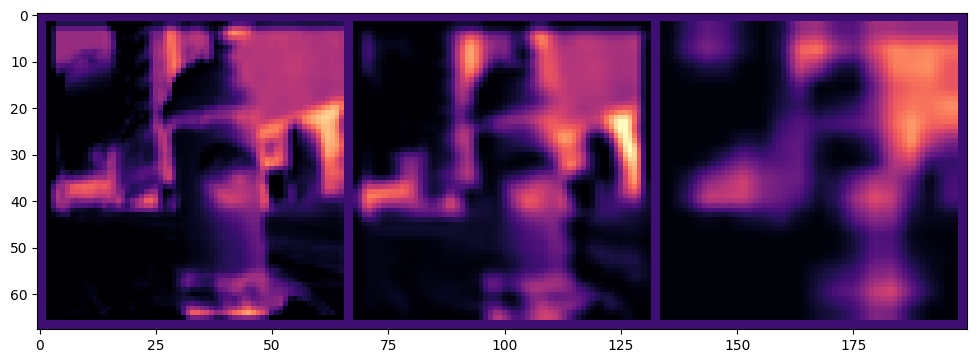

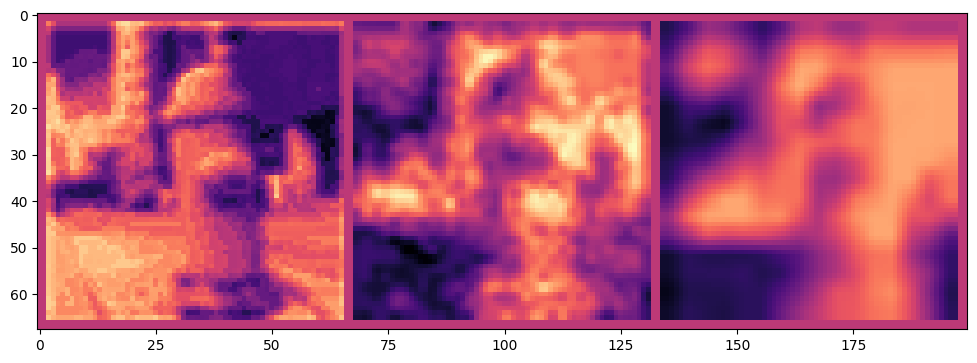

In [38]:
index = 6
layer_index = 3
f = [ resize_image( x[index][layer_index][None], 64 ) for x in features ]
f = [ ( x - x.mean() ) / x.std() for x in f ]
grid = make_grid( f, nrow = 3 )
plt.figure( figsize = ( 12, 12 ) )
plt.imshow( grid.cpu().permute(1, 2, 0)[:,:,0], cmap = 'magma' )
plt.show()

t_ = [ resize_image( x[index][:,:,layer_index][None], 64 ) for x in tokens ]
t_ = [ ( x - x.mean() ) / ( x.std() + 1e-6 ) for x in t_ ]
grid = make_grid( t_, nrow = 3 )
plt.figure( figsize = ( 12, 12 ) )
plt.imshow( grid.cpu().permute(1, 2, 0)[:,:,0], cmap = 'magma' )
plt.show()

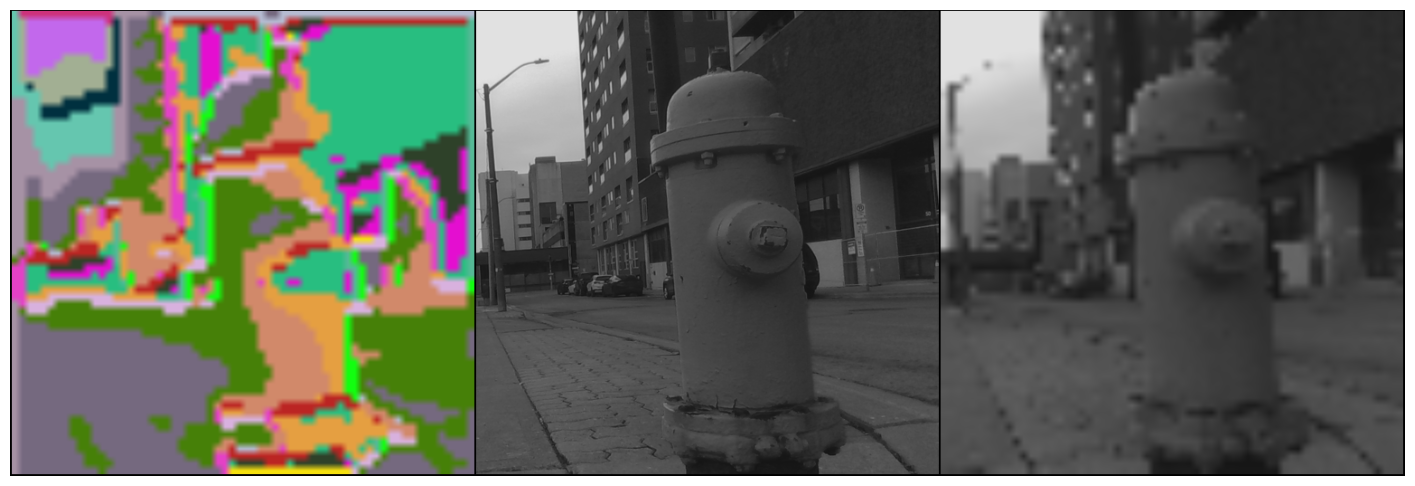

In [39]:
image = features[0][index].cpu().numpy()

channels, s, _ = image.shape

# Reshape the image to have one pixel per row (each pixel is a vector of length 'channels')
pixels = image.reshape(channels, s * s).T  # shape: [s*s, channels]

# Define the number of clusters (for example, 3)
n_clusters = 20
random_colors = np.random.rand(n_clusters, 3)

# Initialize and fit the GMM
# cluster = GaussianMixture(n_components=n_clusters, random_state=0)
# cluster = HDBSCAN( min_cluster_size = 150, min_samples = 150 )
cluster = KMeans( n_clusters = n_clusters )

labels = cluster.fit_predict( pixels )

# Reshape the labels back to the original spatial dimensions
clustered_image = labels.reshape(s, s)
clustered_image = random_colors[clustered_image].transpose(2, 0, 1)
clustered_image = torch.tensor( clustered_image ).to(torch.float32).to(device)

image = make_grid( 
    [ 
        resize_image( clustered_image, 512 ), 
        denormalize( images[index] ), 
        resize_image( resize_image( denormalize( images[index] ), s ), 512 ) 
    ] 
).cpu().numpy()

# Plot the original image
plt.figure(figsize=(18, 12))
plt.imshow(image.transpose(1, 2, 0))
plt.axis('off')
plt.show()

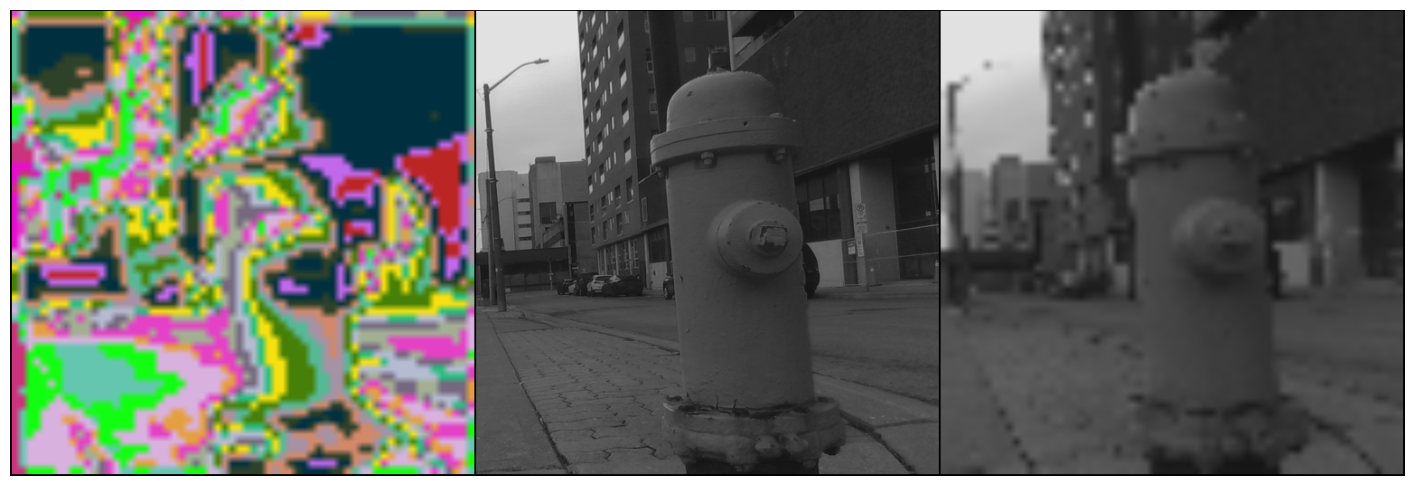

In [47]:
image = tokens[0][index].permute(2, 0, 1).cpu().numpy()

channels, s, _ = image.shape

# Reshape the image to have one pixel per row (each pixel is a vector of length 'channels')
pixels = image.reshape(channels, s * s).T  # shape: [s*s, channels]

# Define the number of clusters (for example, 3)
n_clusters = 20

# Initialize and fit the GMM
# cluster = GaussianMixture(n_components=n_clusters, random_state=0)
# cluster = HDBSCAN( min_cluster_size = 16, min_samples = 16 )
cluster = KMeans( n_clusters = n_clusters )
labels = cluster.fit_predict( pixels )

# Reshape the labels back to the original spatial dimensions
clustered_image = labels.reshape(s, s)
clustered_image = random_colors[clustered_image].transpose(2, 0, 1)
clustered_image = torch.tensor( clustered_image ).to(torch.float32).to(device)

image = make_grid( 
    [ 
        resize_image( clustered_image, 512 ), 
        denormalize( images[index] ), 
        resize_image( resize_image( denormalize( images[index] ), s ), 512 ) 
    ] 
).cpu().numpy()

# Plot the original image
plt.figure(figsize=(18, 12))
plt.imshow(image.transpose(1, 2, 0))
plt.axis('off')
plt.show()

In [ ]:
import torch

BACKBONE_SIZE = "small" # in ("small", "base", "large" or "giant")

backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

backbone_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
backbone_model.eval()
backbone_model.cuda()

In [ ]:
from functools import partial
forward = partial(
    backbone_model.get_intermediate_layers,
    n = [11],
    reshape = False,
    return_class_token = True,
)

In [ ]:
r = forward( torch.randn(1, 3, 224, 224 ).cuda() )[0]

In [ ]:
r[0].shape, r[1].shape

In [ ]:
64*64, 32*32, 16*16

In [ ]:
896,448,224

In [ ]:
900**0.5